# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

GANs were [first reported on](https://arxiv.org/abs/1406.2661) in 2014 from Ian Goodfellow and others in Yoshua Bengio's lab. Since then, GANs have exploded in popularity. Here are a few examples to check out:

* [Pix2Pix](https://affinelayer.com/pixsrv/) 
* [CycleGAN & Pix2Pix in PyTorch, Jun-Yan Zhu](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix)
* [A list of generative models](https://github.com/wiseodd/generative-models)

The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
> * The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

If you're interested in generating only new images, you can throw out the discriminator after training. In this notebook, I'll show you how to define and train these adversarial networks in PyTorch and generate new images!

In [21]:
# import libraries
import torch 
import numpy as np
from torch import nn 
from torch import optim
from torchvision import datasets, transforms 
from torch.utils.data import random_split, DataLoader
# Check cuda availbility 
print('CUDA is available!') if  torch.cuda.is_available() else print('No cuda')
# assign cuda to device
device = torch.device('cuda')
import matplotlib.pyplot as plt
# %matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


CUDA is available!


### Pipeline
- Load the data 
- Visualize the data
- Define Models
  - Discriminator 
  - Generator
- Models hparams 
- Build complete network
- Start the adversarial training

#### Load and Visualize data

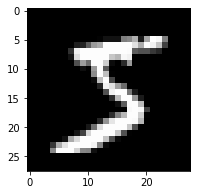

In [22]:
# load train data
train_data = datasets.MNIST(root='data', train= True, transform = transforms.ToTensor(), download=False)

# construct data loader
batch_size = 32
train_loader= DataLoader(train_data, batch_size=32)

# visualize data

# get one batch of data

images, labels = iter(train_loader).next()

# get one image 

single_image = np.squeeze(images.numpy()[0])

# plot
fig= plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(single_image, cmap='gray')
plt.show()

#### Define the Models

##### Discrimintor model

In [11]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()
        
        self.disc_network = nn.Sequential(
                        # layer 1
                        nn.Linear(input_size, hidden_dim*4),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
            
                        # layer 2
                        nn.Linear(hidden_dim*4, hidden_dim*2),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
            
                        # layer 3
                        nn.Linear( hidden_dim*2, hidden_dim),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
            
                        # final layer
                        nn.Linear(hidden_dim, output_size))
        
    def forward(self, x):
        # flatten image
        x = x.view(-1, 28*28)

        # pass data to discriminator
        out = self.disc_network(x)

        return out

##### Generator model

In [12]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super().__init__()
        
        self.generator = nn.Sequential(
                        # layer 1
                        nn.Linear(input_size, hidden_dim),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
            
                        # layer 2
                        nn.Linear(hidden_dim, hidden_dim*2),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
            
                        # layer 3
                        nn.Linear( hidden_dim*2, hidden_dim*4),
                        nn.LeakyReLU(0.2),
                        nn.Dropout(0.3),
            
                        # final layer
                        nn.Linear(hidden_dim*4, output_size),
                        # specifc for generator to scale output between -1 and 1
                        nn.Tanh())
        
    def forward(self, x):

        # pass data to discriminator
        out = self.generator(x)

        return out

#### Models Hpaarams

In [23]:
## Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

## Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

#### Construct Complete Network

In [24]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print(G)

Discriminator(
  (disc_network): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)
Generator(
  (generator): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_

#### Optimizers and losses

In [25]:
# Optimizers
lr = 0.002

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

# loss
criterion = nn.BCEWithLogitsLoss()

In [26]:
import pickle as pkl

# training hyperparams
num_epochs = 10

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        ## 1. Train with real images

        # Compute the discriminator losses on real images 
        D_real = D(real_images)
        
        # create true labels for real images 
        true_labels = torch.ones(batch_size)
        # calculate loss on true images
        d_real_loss = criterion(D_real.squeeze(), true_labels)

        ## 2. Train with fake images
        # Generate fake images
        # gradients don't have to flow during this step
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            fake_images = G(z)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images)
        
        # define fake images labels as zero
        fake_labels = torch.zeros(batch_size)
        
        
        d_fake_loss = criterion(D_fake.squeeze(), fake_labels)

        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        
        # use flipped labels for fake images
        flip_fake_label = torch.ones(batch_size)
        
        
        g_loss = criterion(D_fake.squeeze(), flip_fake_label) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   10] | d_loss: 1.3930 | g_loss: 0.7431
Epoch [    1/   10] | d_loss: 0.2698 | g_loss: 7.4310
Epoch [    1/   10] | d_loss: 1.1825 | g_loss: 0.9673
Epoch [    1/   10] | d_loss: 1.2655 | g_loss: 0.8937
Epoch [    1/   10] | d_loss: 1.5044 | g_loss: 0.6449
Epoch [    2/   10] | d_loss: 1.0879 | g_loss: 1.0463
Epoch [    2/   10] | d_loss: 0.8940 | g_loss: 1.1116
Epoch [    2/   10] | d_loss: 1.1795 | g_loss: 0.9803
Epoch [    2/   10] | d_loss: 1.1782 | g_loss: 0.8624
Epoch [    2/   10] | d_loss: 0.8100 | g_loss: 1.1242
Epoch [    3/   10] | d_loss: 0.9099 | g_loss: 1.2971
Epoch [    3/   10] | d_loss: 1.2505 | g_loss: 1.0995
Epoch [    3/   10] | d_loss: 1.2524 | g_loss: 1.1140
Epoch [    3/   10] | d_loss: 1.1606 | g_loss: 1.0525
Epoch [    3/   10] | d_loss: 1.2039 | g_loss: 0.8261
Epoch [    4/   10] | d_loss: 1.1802 | g_loss: 1.0706
Epoch [    4/   10] | d_loss: 1.1177 | g_loss: 0.7875
Epoch [    4/   10] | d_loss: 1.0585 | g_loss: 1.0993
Epoch [    4/   10] | d_loss

#### Visualize generated data

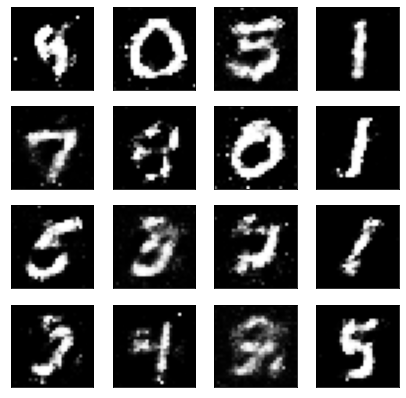

In [20]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples)
